# PROJECT SPRINT 10: A/B TESTING

### DESCRIPTION OF THE PROJECT: This is a test and analysis done for a big online store. Together with the marketing department, I received a list of hypotheses that may help boost revenue.<br>

### PURPOSE OF THE TEST: **Prioritize these hypotheses, launch A/B test and analyze the results.** 

***

### The project is divided into several parts. Each part has its own purpose and is outlined in a sequencial order so you can follow the progress to the end.<br>

>### Part One: Pre-processing of the data.<br>
>### Part Two: Check Compliances.<br>
>### Part Three: Prioritizing Hypotheses.<br>
>### Part Four: Main KPIs (without statistical analysis).<br>
>### Part Five: A/B Test Analysis.<br>
>### Part Six: Conlusions based on the A/B test results.

***

### Description of the data:<br>
> Hypotheses dataset:<br>
> Hypotheses — brief descriptions of the hypotheses<br>
> Reach — user reach, on a scale of one to ten<br>
> Impact — impact on users, on a scale of one to ten<br>
> Confidence — confidence in the hypothesis, on a scale of one to ten<br>
> Effort — the resources required to test a hypothesis, on a scale of one to ten.<br>

> Orders dataset:<br>
> transactionId — order identifier<br>
> visitorId — identifier of the user who placed the order<br>
> date — of the order<br>
> revenue — from the order<br>
> group — the A/B test group that the user belongs to<br>

> Visits dataset:<br>
> date — date<br>
> group — A/B test group<br>
> visits — the number of visits on the date specified in the A/B test group specified

***

### Part One: Pre-processing the data

#### In this part I will import libraries, check and clean the data from both datasets, and check any inconsistencies of the data that may prevent to do further actions and analysis.

**1. Libraries**

In [640]:
# import all the necessary libraries for the whole project
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import sidetable
import plotly.express as px 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 

**2. Reading the datasets and checking for missing values**

In [641]:
# reading the orders csv file
orders = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_10/project/orders_us.csv', parse_dates=['date'])
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [642]:
# info about the dataframe
orders.stb.missing(style=True)

,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


* We can see that there are 1197 rows and no missing vallues.

In [643]:
# reading the visits csv file
visits = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_10/project/visits_us.csv', parse_dates=['date'])
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [644]:
# info about the visits dataframe
visits.stb.missing(style=True)

,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


* We can see that there are 62 rows and no missing values.

In [645]:
# reading the hypotheses csv file
pd.set_option('display.max_colwidth', None)
hypotheses = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_10/project/hypotheses_us.csv')
hypotheses

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. This will bring 30% more users;3;10;8;6
1,Launch your own delivery service. This will shorten delivery time;2;5;4;10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size;8;3;7;3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly;8;3;3;8
4,Change the background color on the main page. This will increase user engagement;3;1;1;1
5,Add a customer review page. This will increase the number of orders;3;2;2;3
6,Show banners with current offers and sales on the main page. This will boost conversion;5;3;8;3
7,Add a subscription form to all the main pages. This will help you compile a mailing list;10;7;8;5
8,Launch a promotion that gives users discounts on their birthdays;1;9;9;5


* We can see that the format is not the correct one to manipulate the data on the dataframe so I will modify the format to make columns.

In [646]:
# define the data as a list of dictionaries
hypotheses = [
    {"Hypothesis": "Add two new channels for attracting traffic. This will bring 30% more users", "Reach": 3, "Impact": 10, "Confidence": 8, "Effort": 6},
    {"Hypothesis": "Launch your own delivery service. This will shorten delivery time", "Reach": 2, "Impact": 5, "Confidence": 4, "Effort": 10},
    {"Hypothesis": "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size", "Reach": 8, "Impact": 3, "Confidence": 7, "Effort": 3},
    {"Hypothesis": "Change the category structure. This will increase conversion since users will find the products they want more quickly", "Reach": 8, "Impact": 3, "Confidence": 3, "Effort": 8},
    {"Hypothesis": "Change the background color on the main page. This will increase user engagement", "Reach": 3, "Impact": 1, "Confidence": 1, "Effort": 1},
    {"Hypothesis": "Add a customer review page. This will increase the number of orders", "Reach": 3, "Impact": 2, "Confidence": 2, "Effort": 3},
    {"Hypothesis": "Show banners with current offers and sales on the main page. This will boost conversion", "Reach": 5, "Impact": 3, "Confidence": 8, "Effort": 3},
    {"Hypothesis": "Add a subscription form to all the main pages. This will help you compile a mailing list", "Reach": 10, "Impact": 7, "Confidence": 8, "Effort": 5},
    {"Hypothesis": "Launch a promotion that gives users discounts on their birthdays; This will increase customer retention", "Reach": 1, "Impact": 9, "Confidence": 9, "Effort": 5},
]
# create the DataFrame
hypotheses = pd.DataFrame(hypotheses)
# Convert column names to lowercase
hypotheses.columns = hypotheses.columns.str.lower()
hypotheses


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays; This will increase customer retention,1,9,9,5


In [647]:
# checking for duplicates on column of transactions
duplicates = orders['transactionId'].duplicated().sum()
if duplicates > 0:
  print(f'There are {duplicates} duplicate rows in the DataFrame.')
else:
  print('No duplicate rows found.')

No duplicate rows found.


* We can see that there are no duplicated transactions on the dataframe.

In [648]:
# group by test group and see when start and when ends the test
orders.groupby(['group'])['date'].agg(['min','max'])

,min,max
group,,
A,2019-08-01,2019-08-31
B,2019-08-01,2019-08-31


* We can see that both orders and visits dataframes have same start and end dates.

***

### Part Two: Check compliances

#### In this part I will go through all the technical requirements that need to be fulfilled in order to perform a correct test.

In [649]:
# group by group to see how many users on each group
users_per_group = orders.groupby(['group'])['visitorId'].nunique().reset_index()
users_per_group

,group,visitorId
0,A,503
1,B,586


In [650]:
# filter entries for groups A and B
groupA = users_per_group[users_per_group['group'] == 'A']['visitorId'].iloc[0]
groupB = users_per_group[users_per_group['group'] == 'B']['visitorId'].iloc[0]
# calculate the difference
difference = groupB - groupA
print(f'There is a difference of {difference} users between group A and B')

There is a difference of 83 users between group A and B


* We can see there is not an even split of the groups, there is a difference of 83 users. I will check if there are users that are included on both groups by error on the next step.

In [651]:
# pylint: disable=missing-final-newline
# users in both groups
both_groups = list(orders.groupby(['visitorId'])['group'].nunique().reset_index().query('group > 1')['visitorId'])
both_groups

[8300375,
 199603092,
 232979603,
 237748145,
 276558944,
 351125977,
 393266494,
 457167155,
 471551937,
 477780734,
 818047933,
 963407295,
 1230306981,
 1294878855,
 1316129916,
 1333886533,
 1404934699,
 1602967004,
 1614305549,
 1648269707,
 1668030113,
 1738359350,
 1801183820,
 1959144690,
 2038680547,
 2044997962,
 2378935119,
 2458001652,
 2579882178,
 2587333274,
 2600415354,
 2654030115,
 2686716486,
 2712142231,
 2716752286,
 2780786433,
 2927087541,
 2949041841,
 2954449915,
 3062433592,
 3202540741,
 3234906277,
 3656415546,
 3717692402,
 3766097110,
 3803269165,
 3891541246,
 3941795274,
 3951559397,
 3957174400,
 3963646447,
 3972127743,
 3984495233,
 4069496402,
 4120364173,
 4186807279,
 4256040402,
 4266935830]

In [652]:
# not in both groups
clean_orders = orders[(orders.visitorId.apply(lambda x: x not in both_groups))]
clean_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


* We can see now that the clean list of users which is valid for the test is the users that are only participating in one version of the test.

In [653]:
# group by group to see how many users on each group
users_by_group = clean_orders.groupby(['group'])['visitorId'].nunique().reset_index()
users_by_group

,group,visitorId
0,A,445
1,B,528


In [654]:
# filter entries for groups A and B
groupA = users_by_group[users_by_group['group'] == 'A']['visitorId'].iloc[0]
groupB = users_by_group[users_by_group['group'] == 'B']['visitorId'].iloc[0]
# calculate the difference
difference = groupB - groupA
print(f'There is a difference of {difference} users between group A and B')

There is a difference of 83 users between group A and B


* We can see that there is a difference of 83 users that take part of group A and B to do the test. The difference is quite significant to continue correctly the test.

In [655]:
# double checking if there are still users on both groups
(clean_orders.groupby(['visitorId'])['group'].nunique()>1).sum()

0

* We can see that now each user if participiating only in one only version of the test. The rest of users were dropped from the test.

#### Note: We don't have data on this data sets about the existence of any marketing events during this period of August, neither the existence of special promotions or holidays. Therefore, we infer that the planned dates for the test are normal dates that retrieve a usual user behavior.

* We can also infer that there is not existence of ghosts users on the data set, users that are registered but don't take part on any of the versions of the test. I can see that from the missing values and the columns earlier on the datasets information.

***

### Part Three: Prioritizing hypotheses

In [656]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays; This will increase customer retention,1,9,9,5


In [657]:
# apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays; This will increase customer retention,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


In [658]:
# apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays; This will increase customer retention,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


#### From the two prioritization of hypotheses using ICE and RICE I can infer:<br>

* ICE prioritizes based on the following factors:<br>

> Reach (R): The number of users potentially affected by the hypothesis.<br>
> Impact (I): The expected impact of the hypothesis on a relevant metric (e.g., conversion rate, revenue).<br>
> Confidence (C): The level of certainty in your estimates for Reach and Impact.<br>

* RICE prioritizes based on the following factors:<br>

> Reach (R): Same as ICE.<br>
> Impact (I): Similar to ICE, but can consider effort required to implement the hypothesis.<br>
> Confidence (C): Similar to ICE.<br>
> Effort (E): The amount of time and resources needed to implement the hypothesis.<br>

* Changes in Prioritization:<br>

> Subscription form: With RICE, the "subscription form" hypothesis jumps to the top due to its high Reach and potentially high Impact on acquiring leads (assuming a good conversion rate).<br>
> Product recommendations: This hypothesis also moves up significantly in RICE due to a balance between Reach, Impact, and lower Effort compared to some ideas in ICE.<br>
> Discounts and new channels: While still considered valuable, these drop in priority with RICE because the Effort to implement them might be higher.<br>

* Key Takeaways:<br>

> RICE incorporates effort into the prioritization, potentially favoring ideas with high potential impact but lower implementation complexity.<br>
> If user base growth and immediate impact are critical, ICE might be suitable.<br>
> If resource allocation and long-term value are essential, RICE might be a better choice.

***

### Part Four: KPIs

#### Following are KPIs used for further analysis, all the KPIs in this part are calculated with raw data.

##### 1. Revenue per group and Cumulative Revenue per group.

In [659]:
# create general revenue per day
revenue_per_day = clean_orders.groupby(['date', 'group'])['revenue'].sum().reset_index()
revenue_per_day.columns = ['date', 'group', 'revenue_per_day']
revenue_per_day.head()


,date,group,revenue_per_day
0,2019-08-01,A,2266.6
1,2019-08-01,B,967.2
2,2019-08-02,A,1468.3
3,2019-08-02,B,2568.1
4,2019-08-03,A,1815.2


In [660]:
# dataFrame with orders and revenue by day, group A
RevenueA = revenue_per_day[revenue_per_day['group'] == 'A'][['date', 'revenue_per_day']]
# dataFrame with orders and revenue by day, group B
RevenueB = revenue_per_day[revenue_per_day['group'] == 'B'][['date', 'revenue_per_day']]

In [661]:
RevenueA.head(10)

,date,revenue_per_day
0,2019-08-01,2266.6
2,2019-08-02,1468.3
4,2019-08-03,1815.2
6,2019-08-04,675.5
8,2019-08-05,1398.0
10,2019-08-06,668.4
12,2019-08-07,1942.0
14,2019-08-08,1404.8
16,2019-08-09,2095.2
18,2019-08-10,2387.5


In [662]:
# add column with cumulative revenue for group A
RevenueA['cum_RevenueA'] = RevenueA['revenue_per_day'].cumsum()
RevenueA.head(10)

,date,revenue_per_day,cum_RevenueA
0,2019-08-01,2266.6,2266.6
2,2019-08-02,1468.3,3734.9
4,2019-08-03,1815.2,5550.1
6,2019-08-04,675.5,6225.6
8,2019-08-05,1398.0,7623.6
10,2019-08-06,668.4,8292.0
12,2019-08-07,1942.0,10234.0
14,2019-08-08,1404.8,11638.8
16,2019-08-09,2095.2,13734.0
18,2019-08-10,2387.5,16121.5


In [663]:
RevenueB.head(10)

,date,revenue_per_day
1,2019-08-01,967.2
3,2019-08-02,2568.1
5,2019-08-03,1071.6
7,2019-08-04,1531.6
9,2019-08-05,1449.3
11,2019-08-06,3369.3
13,2019-08-07,3435.6
15,2019-08-08,2379.9
17,2019-08-09,1656.2
19,2019-08-10,1674.8


In [664]:
# add column with cumulative revenue for group B
RevenueB['cum_RevenueB'] = RevenueB['revenue_per_day'].cumsum()
RevenueB.head(10)

,date,revenue_per_day,cum_RevenueB
1,2019-08-01,967.2,967.2
3,2019-08-02,2568.1,3535.3
5,2019-08-03,1071.6,4606.9
7,2019-08-04,1531.6,6138.5
9,2019-08-05,1449.3,7587.8
11,2019-08-06,3369.3,10957.1
13,2019-08-07,3435.6,14392.7
15,2019-08-08,2379.9,16772.6
17,2019-08-09,1656.2,18428.8
19,2019-08-10,1674.8,20103.6


***

##### 2. Average Purchase Size for groups and Cumulative Average Purchase Size for groups.

* Orders per day.

In [665]:
# group by date and group and calculate number of unique transactions
orders_per_day = clean_orders.groupby(['date', 'group'])['transactionId'].nunique().reset_index()
orders_per_day.columns = ['date', 'group', 'orders_per_day']
orders_per_day.head()

,date,group,orders_per_day
0,2019-08-01,A,23
1,2019-08-01,B,17
2,2019-08-02,A,19
3,2019-08-02,B,23
4,2019-08-03,A,24


In [666]:
# dataFrame with orders per day, group A
OrdersA = orders_per_day[orders_per_day['group'] == 'A'][['date', 'orders_per_day']]
# dataFrame with orders per day, group B
OrdersB = orders_per_day[orders_per_day['group'] == 'B'][['date', 'orders_per_day']]

In [667]:
# orders for group A
OrdersA.head()

,date,orders_per_day
0,2019-08-01,23
2,2019-08-02,19
4,2019-08-03,24
6,2019-08-04,11
8,2019-08-05,22


In [668]:
OrdersA.head()

,date,orders_per_day
0,2019-08-01,23
2,2019-08-02,19
4,2019-08-03,24
6,2019-08-04,11
8,2019-08-05,22


In [669]:
# add comulative orders for group A
OrdersA['cum_orders_per_dayA'] = OrdersA['orders_per_day'].cumsum()
OrdersA.head(10)

,date,orders_per_day,cum_orders_per_dayA
0,2019-08-01,23,23
2,2019-08-02,19,42
4,2019-08-03,24,66
6,2019-08-04,11,77
8,2019-08-05,22,99
10,2019-08-06,15,114
12,2019-08-07,16,130
14,2019-08-08,14,144
16,2019-08-09,11,155
18,2019-08-10,15,170


In [670]:
# orders for group B
OrdersB.head()

,date,orders_per_day
1,2019-08-01,17
3,2019-08-02,23
5,2019-08-03,14
7,2019-08-04,14
9,2019-08-05,21


In [671]:
# add comulative orders for group B
OrdersB['cum_orders_per_dayB'] = OrdersB['orders_per_day'].cumsum()
OrdersB.head(10)

,date,orders_per_day,cum_orders_per_dayB
1,2019-08-01,17,17
3,2019-08-02,23,40
5,2019-08-03,14,54
7,2019-08-04,14,68
9,2019-08-05,21,89
11,2019-08-06,23,112
13,2019-08-07,23,135
15,2019-08-08,22,157
17,2019-08-09,19,176
19,2019-08-10,22,198


In [672]:
# merge Revenue and Orders for group A
merged_A = RevenueA.merge(OrdersA, how = 'left', on ='date')
merged_A.head(10)

,date,revenue_per_day,cum_RevenueA,orders_per_day,cum_orders_per_dayA
0,2019-08-01,2266.6,2266.6,23,23
1,2019-08-02,1468.3,3734.9,19,42
2,2019-08-03,1815.2,5550.1,24,66
3,2019-08-04,675.5,6225.6,11,77
4,2019-08-05,1398.0,7623.6,22,99
5,2019-08-06,668.4,8292.0,15,114
6,2019-08-07,1942.0,10234.0,16,130
7,2019-08-08,1404.8,11638.8,14,144
8,2019-08-09,2095.2,13734.0,11,155
9,2019-08-10,2387.5,16121.5,15,170


In [673]:
# add columns for average order size and cumulative order size for group A
merged_A['average_order_sizeA'] = merged_A['revenue_per_day'] / merged_A['orders_per_day']
merged_A['cum_avg_order_sizeA'] = merged_A['average_order_sizeA'].cumsum()
merged_A.head(10)

,date,revenue_per_day,cum_RevenueA,orders_per_day,cum_orders_per_dayA,average_order_sizeA,cum_avg_order_sizeA
0,2019-08-01,2266.6,2266.6,23,23,98.547826,98.547826
1,2019-08-02,1468.3,3734.9,19,42,77.278947,175.826773
2,2019-08-03,1815.2,5550.1,24,66,75.633333,251.460107
3,2019-08-04,675.5,6225.6,11,77,61.409091,312.869198
4,2019-08-05,1398.0,7623.6,22,99,63.545455,376.414652
5,2019-08-06,668.4,8292.0,15,114,44.560000,420.974652
6,2019-08-07,1942.0,10234.0,16,130,121.375000,542.349652
7,2019-08-08,1404.8,11638.8,14,144,100.342857,642.692509
8,2019-08-09,2095.2,13734.0,11,155,190.472727,833.165237
9,2019-08-10,2387.5,16121.5,15,170,159.166667,992.331903


In [674]:
# use describe method to see some statistics data.
merged_A['average_order_sizeA'].describe()

count     31.000000
mean     115.512472
std       51.954826
min       42.152941
25%       82.430383
50%      102.275000
75%      140.817222
max      292.635714
Name: average_order_sizeA, dtype: float64

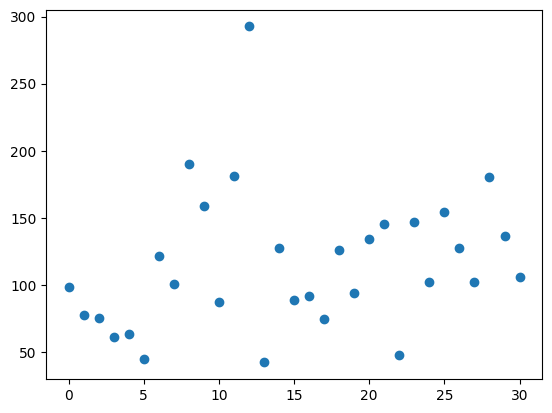

In [675]:
x_values = pd.Series(range(0, len(merged_A['average_order_sizeA'])))
plt.scatter(x_values, merged_A['average_order_sizeA'])

##### We can already infer the existence of some anomalie data on the dataframe as the max. purchase check is over 292.

In [676]:
# merge Revenue and Orders for group B
merged_B = RevenueB.merge(OrdersB, how = 'left', on ='date')
merged_B.head(10)

,date,revenue_per_day,cum_RevenueB,orders_per_day,cum_orders_per_dayB
0,2019-08-01,967.2,967.2,17,17
1,2019-08-02,2568.1,3535.3,23,40
2,2019-08-03,1071.6,4606.9,14,54
3,2019-08-04,1531.6,6138.5,14,68
4,2019-08-05,1449.3,7587.8,21,89
5,2019-08-06,3369.3,10957.1,23,112
6,2019-08-07,3435.6,14392.7,23,135
7,2019-08-08,2379.9,16772.6,22,157
8,2019-08-09,1656.2,18428.8,19,176
9,2019-08-10,1674.8,20103.6,22,198


In [677]:
# add columns for average order size and cumulative order size for group B
merged_B['average_order_sizeB'] = merged_B['revenue_per_day'] / merged_B['orders_per_day']
merged_B['cum_avg_order_sizeB'] = merged_B['average_order_sizeB'].cumsum()
merged_B.head(10)

,date,revenue_per_day,cum_RevenueB,orders_per_day,cum_orders_per_dayB,average_order_sizeB,cum_avg_order_sizeB
0,2019-08-01,967.2,967.2,17,17,56.894118,56.894118
1,2019-08-02,2568.1,3535.3,23,40,111.656522,168.550639
2,2019-08-03,1071.6,4606.9,14,54,76.542857,245.093497
3,2019-08-04,1531.6,6138.5,14,68,109.400000,354.493497
4,2019-08-05,1449.3,7587.8,21,89,69.014286,423.507782
5,2019-08-06,3369.3,10957.1,23,112,146.491304,569.999087
6,2019-08-07,3435.6,14392.7,23,135,149.373913,719.373000
7,2019-08-08,2379.9,16772.6,22,157,108.177273,827.550272
8,2019-08-09,1656.2,18428.8,19,176,87.168421,914.718693
9,2019-08-10,1674.8,20103.6,22,198,76.127273,990.845966


In [678]:
# use describe method to see some statistics data.
merged_B['average_order_sizeB'].describe()

count      31.000000
mean      138.371170
std       172.642632
min        45.931818
25%        87.210526
50%       105.158824
75%       122.813312
max      1050.709524
Name: average_order_sizeB, dtype: float64

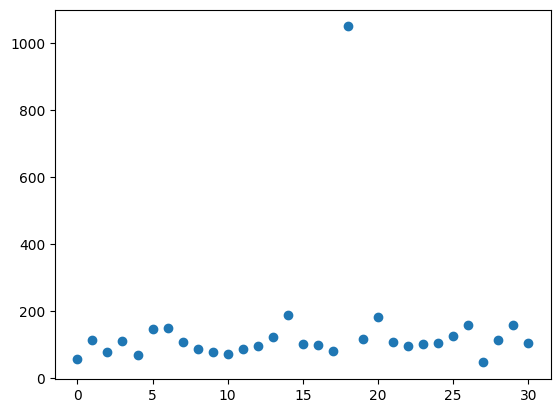

In [679]:
x_values = pd.Series(range(0, len(merged_B['average_order_sizeB'])))
plt.scatter(x_values, merged_B['average_order_sizeB'])

##### We can already infer the existence of some anomalie data on the dataframe as the max. purchase check is over 1050.

***

##### 3. Relative Difference in cumulative average purchase size.

In [680]:
# drop columns from the dataframe that we don't need for this step on group A and B
filtered_merged_A = merged_A.drop(columns = ['revenue_per_day', 'orders_per_day', 'average_order_sizeA'])
filtered_merged_B = merged_B.drop(columns = ['revenue_per_day', 'orders_per_day', 'average_order_sizeB'])


In [681]:
# create relative difference dataframe for group A and B by merging both filtered dataframes
rel_diff_cum_avg_size = filtered_merged_A.merge(filtered_merged_B, how = 'left', on='date')
#create relative difference column for cumulative average purchase size from group A and B
rel_diff_cum_avg_size['rel_diff_cum_avg_size'] = (rel_diff_cum_avg_size['cum_avg_order_sizeB'] / rel_diff_cum_avg_size['cum_avg_order_sizeA'] - 1)
rel_diff_cum_avg_size.head(10)

,date,cum_RevenueA,cum_orders_per_dayA,cum_avg_order_sizeA,cum_RevenueB,cum_orders_per_dayB,cum_avg_order_sizeB,rel_diff_cum_avg_size
0,2019-08-01,2266.6,23,98.547826,967.2,17,56.894118,-0.422675
1,2019-08-02,3734.9,42,175.826773,3535.3,40,168.550639,-0.041382
2,2019-08-03,5550.1,66,251.460107,4606.9,54,245.093497,-0.025319
3,2019-08-04,6225.6,77,312.869198,6138.5,68,354.493497,0.133041
4,2019-08-05,7623.6,99,376.414652,7587.8,89,423.507782,0.125110
5,2019-08-06,8292.0,114,420.974652,10957.1,112,569.999087,0.353999
6,2019-08-07,10234.0,130,542.349652,14392.7,135,719.373000,0.326401
7,2019-08-08,11638.8,144,642.692509,16772.6,157,827.550272,0.287630
8,2019-08-09,13734.0,155,833.165237,18428.8,176,914.718693,0.097884
9,2019-08-10,16121.5,170,992.331903,20103.6,198,990.845966,-0.001497


***

##### 4.  Conversion rate for each group as ratio of orders to number of visits each day.

* Visits per day.

In [682]:
# group by date and group and calculate number of unique visits
visits_per_day = visits.groupby(['date', 'group'])['visits'].sum().reset_index()
visits_per_day.columns = ['date', 'group', 'visits_per_day']
visits_per_day.head()

,date,group,visits_per_day
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507


In [683]:
# dataFrame with visits per day, group A
VisitsA = visits_per_day[visits_per_day['group'] == 'A'][['date', 'visits_per_day']]
VisitsA.head()

,date,visits_per_day
0,2019-08-01,719
2,2019-08-02,619
4,2019-08-03,507
6,2019-08-04,717
8,2019-08-05,756


In [684]:
# dataFrame with visits per day, group A
VisitsB = visits_per_day[visits_per_day['group'] == 'B'][['date', 'visits_per_day']]
VisitsB.head()

,date,visits_per_day
1,2019-08-01,713
3,2019-08-02,581
5,2019-08-03,509
7,2019-08-04,770
9,2019-08-05,707


In [685]:
# merge datasets of orders and visits for group A
conversion_rateA = OrdersA.merge(VisitsA, on = 'date', how = 'left')
conversion_rateA.head(10)

,date,orders_per_day,cum_orders_per_dayA,visits_per_day
0,2019-08-01,23,23,719
1,2019-08-02,19,42,619
2,2019-08-03,24,66,507
3,2019-08-04,11,77,717
4,2019-08-05,22,99,756
5,2019-08-06,15,114,667
6,2019-08-07,16,130,644
7,2019-08-08,14,144,610
8,2019-08-09,11,155,617
9,2019-08-10,15,170,406


In [686]:
# adding conversion column and its calculation to group A
conversion_rateA['conversionA'] = conversion_rateA['orders_per_day'] / conversion_rateA['visits_per_day']
conversion_rateA.head(10)

,date,orders_per_day,cum_orders_per_dayA,visits_per_day,conversionA
0,2019-08-01,23,23,719,0.031989
1,2019-08-02,19,42,619,0.030695
2,2019-08-03,24,66,507,0.047337
3,2019-08-04,11,77,717,0.015342
4,2019-08-05,22,99,756,0.029101
5,2019-08-06,15,114,667,0.022489
6,2019-08-07,16,130,644,0.024845
7,2019-08-08,14,144,610,0.022951
8,2019-08-09,11,155,617,0.017828
9,2019-08-10,15,170,406,0.036946


In [687]:
# merge datasets of orders and visits for group B
conversion_rateB = OrdersB.merge(VisitsB, on = 'date', how = 'left')
conversion_rateB.head(10)

,date,orders_per_day,cum_orders_per_dayB,visits_per_day
0,2019-08-01,17,17,713
1,2019-08-02,23,40,581
2,2019-08-03,14,54,509
3,2019-08-04,14,68,770
4,2019-08-05,21,89,707
5,2019-08-06,23,112,655
6,2019-08-07,23,135,709
7,2019-08-08,22,157,654
8,2019-08-09,19,176,610
9,2019-08-10,22,198,369


In [688]:
# adding conversion column and its calculation to group B
conversion_rateB['conversionB'] = conversion_rateB['orders_per_day'] / conversion_rateB['visits_per_day']
conversion_rateB.head(10)

,date,orders_per_day,cum_orders_per_dayB,visits_per_day,conversionB
0,2019-08-01,17,17,713,0.023843
1,2019-08-02,23,40,581,0.039587
2,2019-08-03,14,54,509,0.027505
3,2019-08-04,14,68,770,0.018182
4,2019-08-05,21,89,707,0.029703
5,2019-08-06,23,112,655,0.035115
6,2019-08-07,23,135,709,0.032440
7,2019-08-08,22,157,654,0.033639
8,2019-08-09,19,176,610,0.031148
9,2019-08-10,22,198,369,0.059621


In [689]:
# drop columns from the dataframe that we don't need for this step on group A and B
filtered_conversion_rateA = conversion_rateA.drop(columns = ['orders_per_day', 'visits_per_day'])
filtered_conversion_rateB = conversion_rateB.drop(columns = ['orders_per_day', 'visits_per_day'])

In [690]:
# merge both dataframes to calculate the difference on conversion rate from both groups
merged_conversion_rate = filtered_conversion_rateA.merge(filtered_conversion_rateB, how = 'left', on = 'date')
# aggregate the conversion rates for both groups
total_conversion_A = merged_conversion_rate['conversionA'].sum()
total_conversion_B = merged_conversion_rate['conversionB'].sum()
# calculating the difference in total conversions
conversion_difference = total_conversion_B - total_conversion_A

print(f"Total Conversion for Group A: {total_conversion_A}")
print(f"Total Conversion for Group B: {total_conversion_B}")
print(f"Difference in Total Conversion: {conversion_difference}")

Total Conversion for Group A: 0.8025995157202113
Total Conversion for Group B: 0.9431440869612842
Difference in Total Conversion: 0.1405445712410729


#### Analysis of Results:<br>
> Total Conversion for Group A: 80.26%<br>
> This represents the overall conversion rate for Group A across all dates included in the analysis.<br>

>Total Conversion for Group B: 94.31%<br>

> This represents the overall conversion rate for Group B across all dates included in the analysis.<br>
> Difference in Total Conversion: 14.05 % points.<br>

> This indicates the difference in total conversion rates between Group B and Group A. Group B's total conversion rate is 14.05% points higher than Group A's total conversion rate.

##### 5. Calculation of 95th and 99th percentile for number of orders per user.

* Orders by User.

In [691]:
# group by visitorId and aggregate the number of unique transactionId and min date for group A
ordersByUsersA = clean_orders[clean_orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({
    'transactionId': pd.Series.nunique,
    'date': 'min'
})
ordersByUsersA.columns = ['visitorId', 'orders', 'date']
ordersByUsersA.head()

,visitorId,orders,date
0,11685486,1,2019-08-23
1,54447517,1,2019-08-08
2,66685450,1,2019-08-13
3,78758296,1,2019-08-15
4,85103373,1,2019-08-04


In [692]:
# group by visitorId and aggregate the number of unique transactionId and min date for group B
ordersByUsersB = clean_orders[clean_orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({
    'transactionId': pd.Series.nunique,
    'date': 'min'
})
ordersByUsersB.columns = ['visitorId', 'orders', 'date']
ordersByUsersB.head()

,visitorId,orders,date
0,5114589,1,2019-08-16
1,6958315,1,2019-08-04
2,39475350,1,2019-08-08
3,47206413,1,2019-08-10
4,48147722,1,2019-08-22


In [693]:
# print percentiles for 95 and 99
print(np.percentile(ordersByUsersA['orders'], [95, 99]))
print(np.percentile(ordersByUsersB['orders'], [95, 99]))

[1.   2.56]
[1. 2.]


In [694]:
print(np.percentile(merged_A['average_order_sizeA'], [95, 99]))
print(np.percentile(merged_B['average_order_sizeB'], [95, 99]))

[185.99425837 261.98681818]
[184.93461538 791.4524359 ]


#### Users with orders greater than the 99th percentile, i.e., more than 2.56 orders can be considered outliers for group A and users with 3 orders are outliers of group B because their order count exceeds the 99th percentile.

***

### Part Five: A/B Test Analysis

#### Following are the plots, analysis and conclusions of the data based on earlier KPIs and not taking into consideration the existence of outliers.

##### 1. Scatter plot of Number of orders per user

In [695]:
# plot scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x = ordersByUsersA['date'], 
                        y = ordersByUsersA['orders'],
                    mode = 'markers',
                    name = 'A', marker = dict(color = 'blue')))
fig.add_trace(go.Scatter(x = ordersByUsersB['date'], 
                        y = ordersByUsersB['orders'], 
                    mode = 'markers',
                    name = 'B', marker = dict(color = 'red')))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y',
                  xaxis_title = 'date')

fig.update_yaxes(title_text = 'number of orders')
fig.update_layout(title_text = 'Number of Orders per User',
                  showlegend = True)
fig.show()

/Users/cesarchaparro/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#### Scatter plot for the number of orders per user for groups A and B.<br>

> The x-axis represents the dates from 1st August to 30th August 2019.<br>
> The y-axis represents the number of orders per user.<br>
> Group A’s orders are represented by blue dots, while Group B’s orders are represented by red dots.<br>

> Both groups show users with orders ranging from 1 to 3 per day.<br>
> Group B has a consistent presence of 1 order per user almost every day.<br>
> Group A has occasional instances where users place 2 or 3 orders.<br>

> Group A (blue dots) shows more variability with instances of 2 and 3 orders per user on certain days.<br>
> Group B (red dots) primarily shows 1 order per user, with occasional days showing 2 orders.<br>
> Both groups have days where no orders exceed 1 per user.<br>

> On several days, Group A has users placing 2 or 3 orders, such as around August 4, August 18, and late August.<br>
> Group B shows less frequent but consistent occurrences of users placing 2 orders, notably around August 11 and August 18.<br>

> Users in Group A have more variability in their order behavior, indicating some users might be more active and place multiple orders on certain days.<br>
> Group B users tend to place a single order per day, indicating more consistent but lower activity levels.

In [696]:
ordersByUsersA['orders'].describe()

count    445.000000
mean       1.051685
std        0.267669
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

In [697]:
ordersByUsersB['orders'].describe()

count    528.000000
mean       1.037879
std        0.210008
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

#### Comparative Analysis:<br>

> Both groups have a mean number of orders per user close to 1, with Group A slightly higher at 1.051685 compared to Group B’s 1.037879.<br>
> The median for both groups is 1.0, indicating that more than half of the users in both groups place exactly one order.<br>

> Group A has a higher standard deviation (0.267669) compared to Group B (0.210008), suggesting that Group A’s order counts are more variable.<br>
> The maximum number of orders is 3 for both groups, indicating occasional multiple orders per user, as seen in the scatter plot.<br>

> Group A exhibits slightly more variability in user activity, with a small portion of users placing more than one order per day more frequently than in Group B.<br>
> This aligns with the scatter plot observations where Group A had instances of 2 and 3 orders per user, while Group B was more consistent with 1 order and occasional 2 orders.<br>

> The higher standard deviation in Group A points to greater inconsistency in daily orders, while Group B users show more consistent order behavior, supported by the scatter plot showing fewer instances of multiple orders.

***

##### 2. Plot Conversion Rate by Day for group A and B.

In [698]:
# plot daily conversion rate for groups A and B
fig = go.Figure()
fig.add_trace(go.Scatter(x = conversion_rateA['date'], 
                        y = conversion_rateA['conversionA'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'green', width = 2 )))
fig.add_trace(go.Scatter(x = conversion_rateB['date'], 
                        y = conversion_rateB['conversionB'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'purple', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  xaxis_title = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'conversion rate')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Conversion Rate by Day for group A and B')
fig.update_layout(
    showlegend = True)
fig.show()

/Users/cesarchaparro/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#### The plot shows the daily conversion rates for groups A and B over a period in August 2019.<br>

> The x-axis represents the dates, ranging from 1st August 2019 to 30th August 2019.<br>
> The y-axis represents the conversion rate ratio of orders and number of visits per day, with values ranging from approximately 0.01 to 0.06<br>

> Group A's conversion rates are represented by the green line, while Group B's are shown by the purple line.<br>
> Both groups exhibit considerable variability in their daily conversion rates.<br>
> Both groups show peaks and valleys, indicating days with high and low conversion rates.<br>
> Group A's conversion rate appears to have more frequent and possibly sharper fluctuations than Group B’s. This might suggest greater instability or sensitivity to daily changes in Group A’s conversion rate.<br>
> Group B, while also variable, might show slightly more periods of stability.<br>

> Around August 11, Group B shows a significant spike, reaching a conversion rate above 0.05, while Group A shows a more moderate peak.<br>
> After August 18, Group A shows higher conversion rates more frequently than Group B.<br>
> There are several points where the conversion rates of the two groups intersect, suggesting days where their performance was very similar.

***

##### 3. Plot Orders by Day for group A and B.

In [699]:
# plot orders by day for A/B groups
fig = go.Figure()
fig.add_trace(go.Scatter(x = OrdersA['date'], 
                        y = OrdersA['orders_per_day'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'orange', width = 2 )))
fig.add_trace(go.Scatter(x = OrdersB['date'], 
                        y = OrdersB['orders_per_day'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'blue', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y',
                  xaxis_title = 'date' 
                  )
# Customize y-axis label
fig.update_yaxes(title_text = 'orders_per_day')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Orders by Day for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

***

##### 4. Plot Cumulative Revenue for group A and B.

In [700]:
# plot cumulative revenue for A/B groups
fig = go.Figure()
fig.add_trace(go.Scatter(x = RevenueA['date'], 
                        y = RevenueA['cum_RevenueA'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'orange', width = 2 )))
fig.add_trace(go.Scatter(x = RevenueB['date'], 
                        y = RevenueB['cum_RevenueB'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'blue', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  xaxis_title = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'cumulative revenue')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Cumulative Revenue for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

#### The plot is comparing the revenue performance of two different groups (A and B) over time.<br>
> The x-axis represents the dates, ranging from 1st August 2019 to 30th August 2019.<br>
> The y-axis represents the cumulative revenue in visitors, with values ranging from 0 to 80,000.<br>
> There are two lines on the plot:<br>
> - An orange line representing group A.<br>
> - A blue line representing group B.<br>

#### Trends:<br>

> Both groups start with low cumulative revenue at the beginning of the time period.<br>
> Group A (orange line) shows a relatively steady increase in cumulative revenue throughout the month.<br>
> Group B (blue line) also shows a steady increase initially but has a significant jump around mid-August, after which it continues to grow steadily but at a higher rate compared to group A.<br>

#### Key Observations:<br>

> The sudden spike in the blue line around mid-August suggests that group B experienced a significant event or change that greatly increased its cumulative revenue. This could be due to a successful marketing campaign, a product launch, or another impactful event.<br>
> Group A shows a more consistent and linear growth pattern, suggesting steady but slower improvements over time.

***

##### 5. Scatter plot Average Purchase Size for group A and B.

In [701]:
# scatter plot average purchase size for groups A and B
fig = go.Figure()
fig.add_trace(go.Scatter(x = merged_A['date'], 
                        y = merged_A['average_order_sizeA'],
                    mode = 'markers',
                    name = 'A', line = dict(color = 'green', width = 2 )))
fig.add_trace(go.Scatter(x = merged_B['date'], 
                        y = merged_B['average_order_sizeB'], 
                    mode = 'markers',
                    name = 'B', line = dict(color = 'purple', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  xaxis_title = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'average purchase size')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Average Purchase Size for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

##### Thew scatter plot is comparing the average purchase size for group A and B.<br>

> The x-axis represents dates from 1st August to 30th August 2019.<br>
> The y-axis represents the average purchase size.<br>
> Group A's average purchase sizes are represented by green dots, while Group B's are represented by purple dots.<br>

> Most data points for both groups lie below 200 in average purchase size.<br>
> There are some outliers, notably around August 18, where Group A has an average purchase size of over 1000, while all points for Group B seem to be under 200, indicating more consistent purchase sizes.<br>
> Group A shows more extreme outliers compared to Group B.<br>

> The scatter plot shows that both groups A and B typically have small average purchase sizes, with occasional high-value purchases.<br>

> We can also infer the existence of some outliers for group A and B.

##### 6. Plot Cumulative Average Purchase Size for group A and B.

In [702]:
# pylint: disable=undefined-variable
fig = go.Figure()
fig.add_trace(go.Scatter(x = merged_A['date'], 
                        y = merged_A['cum_avg_order_sizeA'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'green', width = 2 )))
fig.add_trace(go.Scatter(x = merged_B['date'], 
                        y = merged_B['cum_avg_order_sizeB'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'purple', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  xaxis_title = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'cumulative average purchase size')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Cumulative Average Purchase Size for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

#### The plot is comparing the average purchase size of two different groups (A and B) over time.

> The x-axis represents the dates, ranging from 1st August 2019 to 30th August 2019.<br>
> The y-axis represents the average purchase size, with values ranging from 60 to 160.<br>
> There are two lines on the plot:<br>
> - A green line representing group A.<br>
> - A purple line representing group B.<br>

#### Trends:<br>

>Until mid-August, both groups follow a similar trajectory, with Group A slightly higher at some points and Group B at others.<br>
> Around August 18, there is a noticeable divergence where Group B's cumulative average purchase size increases sharply compared to Group A.<br>
> After this divergence, Group B maintains a higher cumulative average purchase size than Group A for the rest of the period.<br>

#### Comparison:<br>

> The sustained higher cumulative average for Group B post-divergence indicates a potentially more effective strategy or more engaged user base compared to Group A.<br>

#### Key Observations:<br>

> The initial part of the month shows both groups with similar average purchase sizes, hovering around the 80-100 range.<br>
> Group B’s sudden increase in mid-August suggests an impactful event or strategy that significantly boosted their average purchase size.<b.>

***

##### 7. Plot Relative Difference for Cumulative Average Purchase Size.

In [703]:
# plotting relative difference for the average purchase sizes
fig = px.line(rel_diff_cum_avg_size,
              x = rel_diff_cum_avg_size['date'],
              y = rel_diff_cum_avg_size['rel_diff_cum_avg_size'],
              title = 'Relative Difference for Cumulative Average Purchase Size')
#adding reference line
fig.add_hline(y = 0,
              line_dash = 'dash',
              line_color = 'purple')
fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y')
fig.show()

/Users/cesarchaparro/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#### The plot is comparing the relative difference between two groups (A and B) over time in terms of their cumulative average purchase size.<br>

> The x-axis represents the dates, ranging from 1st August 2019 to 30th August 2019.<br>
> The y-axis represents the relative difference, with values ranging from approximately -0.4 to 0.4.<br>
> There is a single blue line representing the relative difference over time.<br>
> The horizontal dashed purple line represents the zero line, which serves as a reference point where the relative difference is zero.<br>

#### Trends:<br>

> At the beginning of the period, the relative difference starts below zero, indicating that the average purchase size for group A was lower than that for group B.<br>
> The relative difference increases rapidly, crosses the zero line, and goes positive, indicating that at some point, the average purchase size for group A was higher than that for group B.<br>
> The relative difference then shows fluctuations, going above and below the zero line, indicating changes in which group had a higher average purchase size.<br>
> Around mid-August, there's a sharp increase in the relative difference, indicating a significant event that caused group B’s average purchase size to exceed group A’s substantially.<br>
> Post mid-August, the relative difference remains positive but shows a gradual decrease, indicating that while group B maintained a higher average purchase size, the difference between the two groups started to diminish slightly towards the end of August.<br>

#### Key Observations:<br>

> The sharp increase around mid-August corresponds to the significant spike observed in the average purchase size plot for group B.<br>
> The fluctuations around the zero line indicate a competitive interaction between the two groups' average purchase sizes before the mid-August spike.<br>
>After the spike, group B consistently has a higher average purchase size than group A, as indicated by the relative difference staying positive.


##### 8. Statistical Significance of difference in conversion.

In [704]:
# create the variables ordersByUsersA to store the columns ['userId', 'orders']
ordersByUsersA = clean_orders[clean_orders['group'] == 'A'].groupby('visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'transactions']
# create the variables ordersByUsersB to store the columns ['userId', 'orders']
ordersByUsersB = clean_orders[clean_orders['group'] == 'B'].groupby('visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'transactions']

In [705]:
# declare the variables sampleA and sampleB, with users from different groups and corresponding numbers of orders
# used the np.arange() function to create a list of indices
# pass the argument that specifies that Series objects are to be concatenated by row
# using the mean() method, we'll find the mean for sampleA and sampleB
sampleA = pd.concat([ordersByUsersA['transactions'],pd.Series(0, index = np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['transactions'])), name = 'transactions')],axis = 0)

sampleB = pd.concat([ordersByUsersB['transactions'],pd.Series(0, index = np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['transactions'])), name = 'transactions')],axis = 0)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# print the relative conversion gain for group B
print('{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


##### p-value: 0.011:<br>

> A p-value of 0.011 is relatively low. It indicates that there's only a 1.1% chance of observing such results if there truly were no underlying effects. This suggests we can reject the null hypothesis with a high degree of confidence (98.9%).<br>

##### Relative Conversion Gain: 16%<br>

> This indicates that Group B's conversion rate is 16% higher than Group A's conversion rate.<br>
> This relative gain is substantial and suggests that whatever changes or interventions were applied to Group B had a positive impact on conversion rates compared to Group A.

##### 9. Statistical Significance of difference in average purchase size. 

In [706]:
# pass the data on revenue to the mannwhitneyu() criterion
print('{0:.3f}'.format(stats.mannwhitneyu(clean_orders[clean_orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('{0:.3f}'.format(clean_orders[clean_orders['group']=='B']['revenue'].mean() / clean_orders[clean_orders['group'] == 'A']['revenue'].mean() - 1))

0.736
0.278


##### P-value: 0.736<br>

> This p-value is much greater than the typical significance level of 0.05.<br>
> A high p-value indicates that there is no statistically significant difference in average order sizes between Group A and Group B.<br>
> In other words, the observed difference in average order sizes is likely due to random chance, and we fail to reject the null hypothesis.<br>

##### Relative Difference in Average Order Size: 27.8%<br>

> This value suggests that the average order size for Group B is 27.8% higher than that for Group A.<br>
> Although this seems like a substantial increase, it is not statistically significant according to the Mann-Whitney U test.

***

##### Filtered Data without outliers on orders by user.

#### Since there is some anomalie in group A and group B, users with more than 2.56 orders in group A and users with 3 orders in group B, I will filter the data removing these outliers.

In [707]:
# find the total number of anomalous users using the shape() method
outliers_users = pd.concat([ordersByUsersA[ordersByUsersA['transactions'] > 2.56]['visitorId'], ordersByUsersB[ordersByUsersB['transactions'] >= 3]['visitorId']], axis = 0)
filtered_outliers_users = outliers_users.drop_duplicates().sort_values()
print(filtered_outliers_users.head(10))
print(filtered_outliers_users.shape)

33      249864742
58      611059232
211    2108163459
347    2742574263
310    2988190573
409    3908431265
416    3967698036
Name: visitorId, dtype: int64
(7,)


##### We found 7 users with some anomalie data on the orders that may jeopardize the analysis of usual behavior of users in general.

##### 10. Statistical significance of the differences in conversion between the groups, using filtered data.

In [708]:
# calculate the statistical significance of the differences in conversion for group A, using filtered data
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(filtered_outliers_users))]['transactions'],pd.Series(0, index = np.arange(visits[visits['group'] == 'A']['visits'].sum() - len(ordersByUsersA['transactions'])), name = 'transactions')], axis = 0)
# calculate the statistical significance of the differences in conversion for group B, using filtered data
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(filtered_outliers_users))]['transactions'],pd.Series(0, index = np.arange(visits[visits['group'] == 'B']['visits'].sum() - len(ordersByUsersB['transactions'])), name = 'transactions')], axis = 0)

In [709]:
# apply the statistical Mann-Whitney criterion to the resulting samples
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.008
0.185


##### P-value: 0.08<br>

> A p-value of 0.08 indicates that the difference in conversion rates between Group A and Group B is not statistically significant at the 5% significance level.<br>
> Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This means we do not have strong enough evidence to claim that the conversion rates of the two groups are significantly different when outliers are filtered out.<br>

##### Relative Conversion Gain: 18.5%<br>

> This indicates that, even after filtering outliers, Group B's conversion rate is 18.5% higher than Group A's conversion rate.<br>
> The practical significance is even higher than with the raw data, suggesting that the observed effect is robust and consistent even after removing outliers.<br>

##### 11. Statistical Significance of difference in average purchase size, using filtered data. 

In [710]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    clean_orders[np.logical_and(
        clean_orders['group'] == 'A',
        np.logical_not(clean_orders['visitorId'].isin(filtered_outliers_users)))]['revenue'],
    clean_orders[np.logical_and(
        clean_orders['group'] == 'B',
        np.logical_not(clean_orders['visitorId'].isin(filtered_outliers_users)))]['revenue'])[1]))

print('{0:.3f}'.format(
    clean_orders[np.logical_and(clean_orders['group'] == 'B',np.logical_not(clean_orders['visitorId'].isin(filtered_outliers_users)))]['revenue'].mean() / 
    clean_orders[np.logical_and(
        clean_orders['group'] == 'A',
        np.logical_not(clean_orders['visitorId'].isin(filtered_outliers_users)))]['revenue'].mean() - 1))

0.749
0.279


##### The p-value: 0.749<br>

> After filtering out outliers, indicates no statistically significant difference between the groups. The slight increase in the p-value further confirms the lack of a significant difference.<br>

> Conclusion: Both p-values are well above the common significance threshold of 0.05, meaning we fail to reject the null hypothesis in both cases. The filtering of outliers does not significantly change the conclusion regarding the statistical significance.

##### The relative conversion gain: 0.279<br> 

> After filtering out outliers suggests a similar difference, with Group B having an average purchase size that is 27.9% higher than Group A.<br>

> Conclusion: The relative conversion gain is nearly identical before and after filtering outliers, indicating that the outliers had a minimal impact on the average purchase size difference between the groups.<br>
> The analysis shows consistent findings before and after filtering outliers. Both p-values are high, indicating no statistical significance, and the relative conversion gains are similar, indicating a practical difference in average purchase size.<br>
> Filtering outliers did not materially change the results, suggesting that the outliers were not significantly skewing the data.<br>



***

### Final Conclusion:<br>

### Recommendation<br>

### Option 3: Continue the test.<br>

> Statistical Significance: The current p-values suggest no significant difference, but the practical differences observed warrant further investigation.<br>
> Practical Significance: Group B shows higher average order sizes and a significant revenue spike, indicating potential for better performance.<br>

> Consistency and Trends: Group B's more stable order behavior and significant events around mid-August need further exploration to confirm their long-term impact.<br>

> Extended Monitoring: Continue collecting data to see if trends persist or if the observed differences become statistically significant.<br>

> By continuing the test, we can make a more informed decision with greater confidence in the results, considering both statistical and practical implications.

***

## END OF PROJECT